In [6]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import re


from torch_geometric.data import HeteroData, Batch
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import LinkNeighborLoader
from sklearn.manifold import TSNE

In [7]:
# =========================
# 1. Build the Heterogeneous Graph
# =========================

def get_graph(dataset_folder):
    # Load edge data (convert lists to tensors if necessary)
    # Recipe -> Ingredient edges
    r_i_src, r_i_dst, r_i_weight = torch.load(os.path.join(dataset_folder, 'edge_r2i_src_dst_weight.pt'))
    r_i_src = torch.tensor(r_i_src, dtype=torch.long)
    r_i_dst = torch.tensor(r_i_dst, dtype=torch.long)
    r_i_weight = torch.tensor(r_i_weight, dtype=torch.float)

    # Recipe -> Recipe edges
    r_r_src, r_r_dst, r_r_weight = torch.load(os.path.join(dataset_folder, 'edge_r2r_src_and_dst_and_weight.pt'))
    r_r_src = torch.tensor(r_r_src, dtype=torch.long)
    r_r_dst = torch.tensor(r_r_dst, dtype=torch.long)
    r_r_weight = torch.tensor(r_r_weight, dtype=torch.float)

    # Ingredient -> Ingredient edges
    i_i_src, i_i_dst, i_i_weight = torch.load(os.path.join(dataset_folder, 'edge_i2i_src_and_dst_and_weight.pt'))
    i_i_src = torch.tensor(i_i_src, dtype=torch.long)
    i_i_dst = torch.tensor(i_i_dst, dtype=torch.long)
    i_i_weight = torch.tensor(i_i_weight, dtype=torch.float)

    # User -> Recipe edges (all, train, val, test splits)
    all_u2r = torch.load(os.path.join(dataset_folder, 'all_train_val_test_edge_u_rate_r_src_and_dst_and_weight.pt'))
    # all_u2r is a tuple: (all, train, val, test)
    all_u2r_src_dst_weight = all_u2r[0]
    train_u2r_src_dst_weight = all_u2r[1]
    val_u2r_src_dst_weight = all_u2r[2]
    test_u2r_src_dst_weight = all_u2r[3]
    
    # For the full graph, we use "all" edges:
    u_rate_r_src, u_rate_r_dst, u_rate_r_weight = all_u2r_src_dst_weight
    u_rate_r_src = torch.tensor(u_rate_r_src, dtype=torch.long)
    u_rate_r_dst = torch.tensor(u_rate_r_dst, dtype=torch.long)
    u_rate_r_weight = torch.tensor(u_rate_r_weight, dtype=torch.float)

    # Number of nodes (from your logs)
    num_recipe = 68794
    num_ingredient = 8847
    num_user = 7959

    data = HeteroData()
    data['recipe'].num_nodes = num_recipe
    data['ingredient'].num_nodes = num_ingredient
    data['user'].num_nodes = num_user

    # Add edges for each relation
    # recipe -> ingredient ("r-i")
    data['recipe', 'r-i', 'ingredient'].edge_index = torch.stack([r_i_src, r_i_dst], dim=0)
    data['recipe', 'r-i', 'ingredient'].edge_weight = r_i_weight
    # ingredient -> recipe ("i-r")
    data['ingredient', 'i-r', 'recipe'].edge_index = torch.stack([r_i_dst, r_i_src], dim=0)
    data['ingredient', 'i-r', 'recipe'].edge_weight = r_i_weight

    # recipe -> recipe ("r-r")
    data['recipe', 'r-r', 'recipe'].edge_index = torch.stack([r_r_src, r_r_dst], dim=0)
    data['recipe', 'r-r', 'recipe'].edge_weight = r_r_weight

    # ingredient -> ingredient ("i-i")
    data['ingredient', 'i-i', 'ingredient'].edge_index = torch.stack([i_i_src, i_i_dst], dim=0)
    data['ingredient', 'i-i', 'ingredient'].edge_weight = i_i_weight

    # user -> recipe ("u-r")
    data['user', 'u-r', 'recipe'].edge_index = torch.stack([u_rate_r_src, u_rate_r_dst], dim=0)
    data['user', 'u-r', 'recipe'].edge_weight = u_rate_r_weight

    # recipe -> user ("r-u")
    data['recipe', 'r-u', 'user'].edge_index = torch.stack([u_rate_r_dst, u_rate_r_src], dim=0)
    data['recipe', 'r-u', 'user'].edge_weight = u_rate_r_weight

    # (Optional) Make the graph undirected if desired.
    # data = ToUndirected()(data)

    # Load node features
    recipe_instr_features = torch.load(os.path.join(dataset_folder, 'recipe_nodes_avg_instruction_features.pt'))
    ingredient_nutrient_features = torch.load(os.path.join(dataset_folder, 'ingredient_nodes_nutrient_features.pt'))
    data['recipe'].x = recipe_instr_features   # shape: [68794, feature_dim_recipe]
    data['ingredient'].x = ingredient_nutrient_features  # shape: [8847, feature_dim_ingredient]

    return data, all_u2r, train_u2r_src_dst_weight, val_u2r_src_dst_weight, test_u2r_src_dst_weight

dataset_folder = "data/"
data, all_u2r, train_u2r_src_dst_weight, val_u2r_src_dst_weight, test_u2r_src_dst_weight = get_graph(dataset_folder)
print(data)

HeteroData(
  recipe={
    num_nodes=68794,
    x=[68794, 1024],
  },
  ingredient={
    num_nodes=8847,
    x=[8847, 46],
  },
  user={ num_nodes=7959 },
  (recipe, r-i, ingredient)={
    edge_index=[2, 463485],
    edge_weight=[463485],
  },
  (ingredient, i-r, recipe)={
    edge_index=[2, 463485],
    edge_weight=[463485],
  },
  (recipe, r-r, recipe)={
    edge_index=[2, 647146],
    edge_weight=[647146],
  },
  (ingredient, i-i, ingredient)={
    edge_index=[2, 146188],
    edge_weight=[146188],
  },
  (user, u-r, recipe)={
    edge_index=[2, 135353],
    edge_weight=[135353],
  },
  (recipe, r-u, user)={
    edge_index=[2, 135353],
    edge_weight=[135353],
  }
)


In [8]:
for node_type in data.node_types:
    print(f"{node_type} has {data[node_type].num_nodes} nodes, x shape = {data[node_type].x.shape if 'x' in data[node_type] else 'no features'}")

for edge_type in data.edge_types:
    edge_idx = data[edge_type].edge_index
    print(f"Edge type {edge_type} has {edge_idx.size(1)} edges, edge_weight shape = {data[edge_type].edge_weight.shape if 'edge_weight' in data[edge_type] else 'no weights'}")

recipe has 68794 nodes, x shape = torch.Size([68794, 1024])
ingredient has 8847 nodes, x shape = torch.Size([8847, 46])
user has 7959 nodes, x shape = no features
Edge type ('recipe', 'r-i', 'ingredient') has 463485 edges, edge_weight shape = torch.Size([463485])
Edge type ('ingredient', 'i-r', 'recipe') has 463485 edges, edge_weight shape = torch.Size([463485])
Edge type ('recipe', 'r-r', 'recipe') has 647146 edges, edge_weight shape = torch.Size([647146])
Edge type ('ingredient', 'i-i', 'ingredient') has 146188 edges, edge_weight shape = torch.Size([146188])
Edge type ('user', 'u-r', 'recipe') has 135353 edges, edge_weight shape = torch.Size([135353])
Edge type ('recipe', 'r-u', 'user') has 135353 edges, edge_weight shape = torch.Size([135353])


In [9]:
def create_split_data(data, split_u2r):
    """
    Given a HeteroData object and a tuple split_u2r = (src, dst, weight),
    update the "u-r" and "r-u" relations with the provided split.
    """
    split_src, split_dst, split_weight = split_u2r
    split_src = torch.tensor(split_src, dtype=torch.long)
    split_dst = torch.tensor(split_dst, dtype=torch.long)
    split_weight = torch.tensor(split_weight, dtype=torch.float)
    
    data['user', 'u-r', 'recipe'].edge_index = torch.stack([split_src, split_dst], dim=0)
    data['user', 'u-r', 'recipe'].edge_weight = split_weight
    
    data['recipe', 'r-u', 'user'].edge_index = torch.stack([split_dst, split_src], dim=0)
    data['recipe', 'r-u', 'user'].edge_weight = split_weight
    return data

train_data = create_split_data(copy.deepcopy(data), train_u2r_src_dst_weight)
val_data   = create_split_data(copy.deepcopy(data), val_u2r_src_dst_weight)
test_data  = create_split_data(copy.deepcopy(data), test_u2r_src_dst_weight)


In [10]:
from torch_geometric.loader import LinkNeighborLoader
def unify_train_val_collate(data_list):
    """
    A collate function that performs the default PyG collation, 
    then checks if PyG assigned an attribute `edge_label`.
    If so, we copy it into `edge_attr`.
    """
    batch = Batch.from_data_list(data_list)
    edge_store = batch['user','u-r','recipe']
    # If PyG's negative sampler attached `.edge_label`, unify it into `edge_attr`.
    if hasattr(edge_store, 'edge_label'):
        edge_store.edge_attr = getattr(edge_store, 'edge_label')
    return batch

# For training, we use train_data
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 20],
    edge_label_index=('user','u-r','recipe'),
    batch_size=1024,
    shuffle=True,
    neg_sampling_ratio=5,   # built-in negative sampling
    collate_fn=unify_train_val_collate
)

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 20],
    edge_label_index=('user','u-r','recipe'),
    batch_size=128,
    shuffle=False,
    neg_sampling_ratio=5,   # built-in negative sampling
    collate_fn=unify_train_val_collate
)

print('# of batches in train_loader:', len(train_loader))
print('# of batches in val_loader:', len(val_loader))

# of batches in train_loader: 117
# of batches in val_loader: 63


In [74]:
n_test_negs = 100  # number of negatives per positive edge for testing
dataset_folder = "data/"

def load_test_negatives(dataset_folder):
    """
    Loads a dictionary mapping each user ID to a list of negative recipe IDs.
    Expects the file 'test_negatives_100.txt' in dataset_folder.
    """
    user2negs = {}
    filename = os.path.join(dataset_folder, 'test_negatives_100.txt')
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in tqdm(lines, desc="Loading test negatives"):
            line = line.strip()
            if not line:
                continue
            # Assume the first token looks like "(123)" or "u123"
            user_str = line.split('\t')[0]
            user = int(re.sub(r'\D', '', user_str))
            negs = [int(neg) for neg in line.split('\t')[1:]]
            user2negs[user] = negs
    return user2negs

user2negs = load_test_negatives(dataset_folder)

test_edge_store = test_data['user','u-r','recipe']
test_pos_edges = test_edge_store.edge_index  # shape [2, num_test_pos]
# Row 0 = user IDs, row 1 = recipe IDs

# If your test split is a one-edge-per-user scenario, you might gather a dict:
# user2pos = { user_id: recipe_id }
# or if a user can have multiple test recipes, store them in a list.

user2pos = {}
src = test_pos_edges[0].tolist()
dst = test_pos_edges[1].tolist()
for u,r in zip(src, dst):
    user2pos.setdefault(u, []).append(r)  # handle multi-positives if needed

print("Number of test users in user2pos:", len(user2pos))
# Build test_loader with neg_sampling_ratio=0 and our custom collate function.
# `merged_edge_index` is your shape [2, E] tensor
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 20],
    edge_label_index=( ('user','u-r','recipe'), merged_edge_index ),
    edge_label=merged_labels,  # shape [E]
    batch_size=128,
    shuffle=False,
    neg_sampling_ratio=0,
)

print('# of batches in test_loader:', len(test_loader))

Loading test negatives: 100%|██████████| 7959/7959 [00:00<00:00, 89166.38it/s]

Number of test users in user2pos: 7959


NameError: name 'merged_labels' is not defined

In [11]:
data["recipe"]

{'num_nodes': 68794, 'x': tensor([[-4.7577e-07,  5.9157e-04,  7.5761e-16,  ...,  2.6294e-15,
          4.6648e-03,  1.4960e-18],
        [ 6.3345e-09, -2.7700e-05, -1.1196e-16,  ...,  1.6438e-17,
          1.8777e-03,  3.4776e-17],
        [ 5.6043e-07,  4.4443e-04, -8.4138e-14,  ...,  2.6699e-16,
          5.5984e-05,  6.1708e-21],
        ...,
        [ 1.2193e-02,  1.8029e-05, -3.5491e-14,  ...,  2.7744e-13,
          2.0622e-04,  9.3464e-18],
        [ 1.3699e-11,  1.1628e-05, -4.8603e-14,  ...,  6.7128e-16,
          2.4836e-02,  1.6493e-15],
        [ 5.8985e-12,  3.3551e-07, -2.3446e-14,  ...,  3.2265e-13,
          4.8656e-02,  2.3283e-22]])}

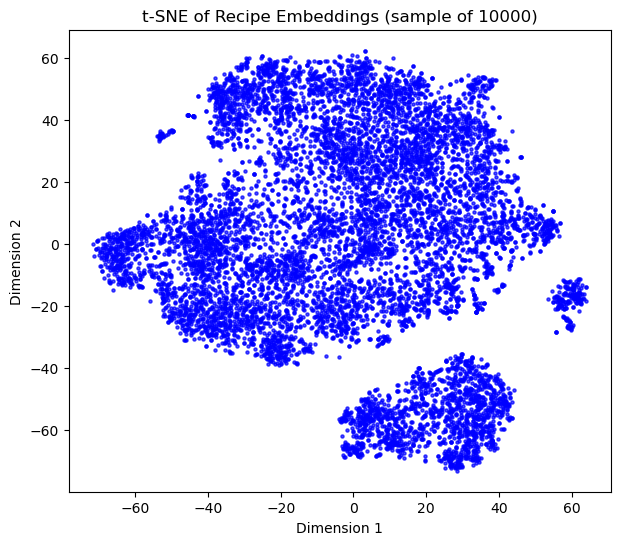

CPU times: user 1min 22s, sys: 12.9 s, total: 1min 35s
Wall time: 11.6 s


In [12]:
%%time
num_recipes = 68794
num_sample = 10000
indices = torch.randperm(num_recipes)[:num_sample]
sample_emb = data["recipe"].x[indices].detach().cpu().numpy()

# Perform TSNE in 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(sample_emb)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.7, c="blue")
plt.title(f"t-SNE of Recipe Embeddings (sample of {num_sample})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

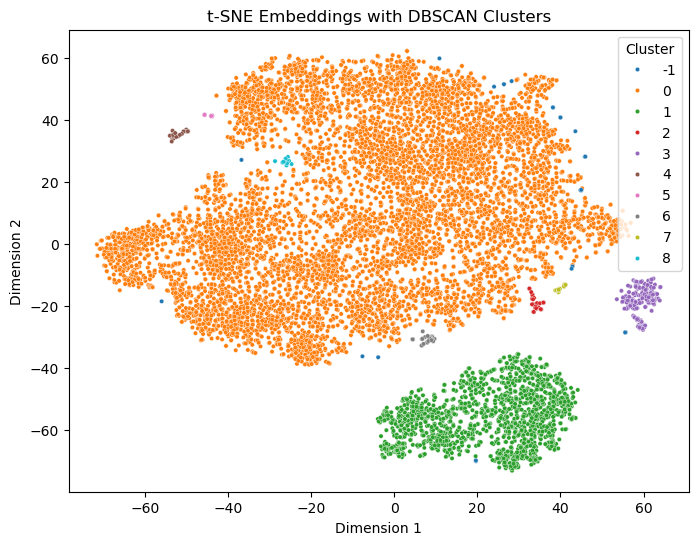

In [14]:
from sklearn.cluster import DBSCAN
import seaborn as sns

# Cluster with DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10)
cluster_labels = dbscan.fit_predict(emb_2d)

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=cluster_labels, palette="tab10", s=10)
plt.title("t-SNE Embeddings with DBSCAN Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [15]:
num_recipes = 68794
indices = torch.randperm(num_recipes)[:num_sample]
sample_emb = data["recipe"].x[indices].detach().cpu().numpy()

In [16]:
import pandas as pd

recipes = pd.read_csv('/Users/samlaborde-balen/Desktop/MLP project/Project/RecipeMAG/data/kaggle_data/RAW_recipes.csv')

# Drop missing essential data and duplicates
recipes.dropna(subset=['name', 'ingredients', 'tags', 'steps'], inplace=True)
recipes.drop_duplicates(subset='name', inplace=True)

# Lowercase text fields for consistency
recipes['ingredients'] = recipes['ingredients'].str.lower()
recipes['tags'] = recipes['tags'].str.lower()

# Create a sub-DataFrame of just the sampled recipes
df_sample = recipes.reset_index(drop=True).iloc[indices].copy()

# Add the DBSCAN cluster labels as a new column
df_sample['cluster_label'] = cluster_labels

In [17]:
for c_id in sorted(df_sample['cluster_label'].unique()):
    cluster_df = df_sample[df_sample['cluster_label'] == c_id]
    cluster_size = len(cluster_df)
    print(f"\n=== Cluster {c_id} ===")
    print(f"Number of recipes in this cluster: {cluster_size}")
    if cluster_size == 0:
        continue
    
    # Dictionary to count how many recipes contain each tag
    tag_counts = {}
    
    for tags_str in cluster_df['tags']:
        # Example format might be "[dessert, easy, kid-friendly]" or "dessert,easy,kid-friendly"
        # We'll handle a few common cases:
        
        # Remove brackets or quotes
        clean = tags_str.strip("[] ").replace("'", "")
        # Split on comma
        splitted = [t.strip() for t in clean.split(',')]
        
        # Use a set to avoid counting duplicates in the same recipe
        unique_tags = set(splitted)
        
        for t in unique_tags:
            if t:  # ignore empty strings
                tag_counts[t] = tag_counts.get(t, 0) + 1
    
    # Convert to a DataFrame to compute proportion easily
    df_tags = (
        pd.DataFrame
        .from_dict(tag_counts, orient='index', columns=['count'])
        .sort_values('count', ascending=False)
    )
    df_tags['proportion'] = df_tags['count'] / cluster_size  # fraction of cluster recipes that have this tag
    
    # Show the top 20 tags
    top_20 = df_tags.head(20)
    print("Top 20 tags (count and proportion):")
    print(top_20)


=== Cluster -1 ===
Number of recipes in this cluster: 28
Top 20 tags (count and proportion):
                    count  proportion
preparation            28    1.000000
time-to-make           28    1.000000
course                 26    0.928571
main-ingredient        22    0.785714
dietary                20    0.714286
occasion               14    0.500000
cuisine                14    0.500000
easy                   13    0.464286
low-in-something       11    0.392857
main-dish              10    0.357143
vegetables             10    0.357143
60-minutes-or-less      9    0.321429
north-american          9    0.321429
30-minutes-or-less      9    0.321429
dinner-party            8    0.285714
low-cholesterol         8    0.285714
low-saturated-fat       7    0.250000
healthy-2               6    0.214286
low-sodium              6    0.214286
15-minutes-or-less      6    0.214286

=== Cluster 0 ===
Number of recipes in this cluster: 8120
Top 20 tags (count and proportion):
             

In [18]:
import pandas as pd

# Assume you already have:
# df_sample = recipes.iloc[indices].copy()
# df_sample["cluster_label"] = cluster_labels

# Helper function to parse tags from a string into a set (to avoid counting duplicates per recipe)
def parse_tags(tags_str):
    # Remove surrounding brackets/quotes if present, then split by comma
    clean = tags_str.strip("[] ").replace("'", "")
    tags = [t.strip() for t in clean.split(',')]
    # Return unique non-empty tags
    return set(t for t in tags if t)

# 1. Compute global tag proportions over the full sample
global_counts = {}
total_recipes = len(df_sample)
for tags_str in df_sample['tags']:
    for tag in parse_tags(tags_str):
        global_counts[tag] = global_counts.get(tag, 0) + 1

global_prop = pd.Series(global_counts) / total_recipes

# 2. For each cluster, compute tag proportions and compare to global proportions
clusters = sorted(df_sample['cluster_label'].unique())
for c_id in clusters:
    cluster_df = df_sample[df_sample['cluster_label'] == c_id]
    cluster_size = len(cluster_df)
    tag_counts = {}
    for tags_str in cluster_df['tags']:
        for tag in parse_tags(tags_str):
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    # Convert counts to proportions (fraction of recipes in this cluster that have the tag)
    cluster_prop = pd.Series(tag_counts) / cluster_size
    
    # 3. Compute the difference (cluster proportion - global proportion)
    # fill missing global proportions with 0 (if a tag only appears in this cluster)
    diff = cluster_prop.subtract(global_prop, fill_value=0)
    
    # Sort descending to see the tags most overrepresented in this cluster
    diff_sorted = diff.sort_values(ascending=False)
    
    print(f"\n=== Cluster {c_id} (n={cluster_size}) ===")
    print("Top 20 distinctive tags (cluster proportion - global proportion):")
    print(diff_sorted.head(20))


=== Cluster -1 (n=28) ===
Top 20 distinctive tags (cluster proportion - global proportion):
low-cholesterol          0.139214
vegetables               0.131743
low-saturated-fat        0.128400
dinner-party             0.124714
canadian                 0.121757
cuisine                  0.114300
healthy-2                0.109186
30-minutes-or-less       0.104129
north-american           0.096729
side-dishes              0.096686
weeknight                0.085871
fish                     0.082643
ground-beef              0.074743
casseroles               0.072943
pasta-rice-and-grains    0.069571
asparagus                0.062529
low-fat                  0.058957
pasta                    0.058743
corn                     0.056829
healthy                  0.054286
dtype: float64

=== Cluster 0 (n=8120) ===
Top 20 distinctive tags (cluster proportion - global proportion):
meat                     0.004704
5-ingredients-or-less    0.003262
main-dish                0.003247
beef            

In [19]:
import pandas as pd

# Assume you already have:
# df_sample = recipes.iloc[indices].copy()
# df_sample["cluster_label"] = cluster_labels

# Helper function to parse tags from a string into a set (to avoid counting duplicates per recipe)
def parse_tags(tags_str):
    # Remove surrounding brackets/quotes if present, then split by comma
    clean = tags_str.strip("[] ").replace("'", "")
    tags = [t.strip() for t in clean.split(',')]
    # Return unique non-empty tags
    return set(t for t in tags if t)

# 1. Compute global tag proportions over the full sample
global_counts = {}
total_recipes = len(df_sample)
for tags_str in df_sample['ingredients']:
    for tag in parse_tags(tags_str):
        global_counts[tag] = global_counts.get(tag, 0) + 1

global_prop = pd.Series(global_counts) / total_recipes

# 2. For each cluster, compute tag proportions and compare to global proportions
clusters = sorted(df_sample['cluster_label'].unique())
for c_id in clusters:
    cluster_df = df_sample[df_sample['cluster_label'] == c_id]
    cluster_size = len(cluster_df)
    tag_counts = {}
    for tags_str in cluster_df['ingredients']:
        for tag in parse_tags(tags_str):
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    # Convert counts to proportions (fraction of recipes in this cluster that have the tag)
    cluster_prop = pd.Series(tag_counts) / cluster_size
    
    # 3. Compute the difference (cluster proportion - global proportion)
    # fill missing global proportions with 0 (if a tag only appears in this cluster)
    diff = cluster_prop.subtract(global_prop, fill_value=0)
    
    # Sort descending to see the tags most overrepresented in this cluster
    diff_sorted = diff.sort_values(ascending=False)
    
    print(f"\n=== Cluster {c_id} (n={cluster_size}) ===")
    print("Top 20 distinctive ingredients (cluster proportion - global proportion):")
    print(diff_sorted.head(20))


=== Cluster -1 (n=28) ===
Top 20 distinctive ingredients (cluster proportion - global proportion):
salt                 0.163914
vegetable oil        0.149586
chili powder         0.110757
pasta                0.103843
black pepper         0.090157
parmesan cheese      0.080857
ground cumin         0.080143
onion                0.078900
fresh asparagus      0.069129
cornmeal             0.065229
onions               0.064643
ice                  0.064529
all-purpose flour    0.058657
white wine           0.058229
dry white wine       0.057229
cilantro             0.056829
cheddar cheese       0.055243
milk                 0.054971
canola oil           0.052629
ground beef          0.047029
dtype: float64

=== Cluster 0 (n=8120) ===
Top 20 distinctive ingredients (cluster proportion - global proportion):
garlic powder                         0.001884
garlic clove                          0.001765
onion                                 0.001683
flour                                 0.001

In [20]:
import pandas as pd

# Load recipes dataset
recipes = pd.read_csv('/Users/samlaborde-balen/Desktop/MLP project/Project/RecipeMAG/data/kaggle_data/RAW_recipes.csv')

# Drop missing essential data and duplicates
recipes.dropna(subset=['name', 'ingredients', 'tags', 'steps'], inplace=True)
recipes.drop_duplicates(subset='name', inplace=True)

# Lowercase text fields for consistency
recipes['ingredients'] = recipes['ingredients'].str.lower()
recipes['tags'] = recipes['tags'].str.lower()

# Nutrition preprocessing function
def preprocess_nutrition(df):
    nutrition_cols = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                      'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
    
    df[nutrition_cols] = df['nutrition'].str.split(",", expand=True)
    df['calories'] = df['calories'].str.replace('[','', regex=False)
    df['carbohydrates (PDV)'] = df['carbohydrates (PDV)'].str.replace(']','', regex=False)
    
    df[nutrition_cols] = df[nutrition_cols].astype(float)
    return df

# Apply nutrition preprocessing
recipes = preprocess_nutrition(recipes)

In [22]:
indices = indices.cpu().numpy()  # torch to numpy if necessary
cluster_labels = cluster_labels  # from DBSCAN
recipes_sampled = recipes.iloc[indices].copy()
recipes_sampled['cluster'] = cluster_labels

In [23]:
nutrition_cols = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                  'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']

nutrition_summary = recipes_sampled.groupby('cluster')[nutrition_cols].mean()
print("\nNutrition profiles by cluster:")
print(nutrition_summary)


Nutrition profiles by cluster:
           calories  total fat (PDV)  sugar (PDV)  sodium (PDV)  \
cluster                                                           
-1       405.992857        24.928571    46.071429     24.107143   
 0       481.673214        37.340887    83.091626     29.180665   
 1       485.776110        38.654700    85.462141     27.304830   
 2       438.700000        33.843750    78.406250     30.843750   
 3       568.925281        40.516854   156.460674    106.151685   
 4       683.259459        51.162162   116.810811     56.702703   
 5       617.413333        48.866667    86.266667     37.733333   
 6       434.133333        33.629630   112.333333     22.888889   
 7       556.393750        51.250000   100.937500     25.125000   
 8       312.700000        25.266667    48.666667     12.933333   

         protein (PDV)  saturated fat (PDV)  carbohydrates (PDV)  
cluster                                                           
-1           32.000000       

## Overview:

### - Cluster –1 (unrelevant) appears to group specialized or healthier recipes with low fat and cholesterol, possibly intended for dinner parties or side dishes.
### - Cluster 0 is a large, general group featuring meat-based, main-dish recipes common in everyday dining.
### - Cluster 1 centers on sweet, dessert-like recipes with distinct Southern or comfort food influences.
### - Cluster 2 (unrelevant) seems to focus on quick, lunch/appetizer-style recipes, potentially featuring seafood.
### - Cluster 3 (not really relevant) is likely a comfort-food cluster with casseroles and kid-friendly, budget-conscious recipes.
### - Cluster 4 (not relevant and weird) might capture healthier or occasion-specific recipes that are quick and inexpensive, though they’re rich in calories.
### - Cluster 5 (not relevant) reflects specialty, high-protein, small-portion recipes with a European or artisanal flair.
### - Cluster 6 (not relevant) blends light, citrusy, dessert-like recipes (or dishes with a sweet twist) that are quick to prepare.
### - Cluster 7 (not relevant) appears to be a niche of quick, American/French style breakfast or brunch items including baked goods.
### - Cluster 8 (not relevant) contains the lightest, most health-oriented recipes—possibly vegan or fruit-based—designed for low-calorie eating.


## Detail:

### Cluster -1 (n=28):
- Distinctive overrepresentation of tags like “low-cholesterol,” “low-saturated-fat,” “vegetables,” “dinner-party,” “side-dishes,” and “weeknight” suggest that these recipes might be designed for health‐conscious dinner parties or quick, lighter side dishes.

### Cluster 0 (n=8120):
- This large cluster shows very common tags—“preparation,” “time-to-make,” “course” are nearly universal. It also emphasizes “main-ingredient,” “dietary,” “easy,” and “occasion.” Distinctive differences include a slight overrepresentation of “meat,” “5-ingredients-or-less,” “main-dish,” “beef,” “european,” and “poultry”. 
- Nutrition: With around 482 calories, higher fat (~37 g) and moderate sugar (~83 g), these recipes seem to be robust, meat-centered main dishes. They might be typical everyday recipes that are hearty and well-suited for large groups or family dinners. 

### Cluster 1 (n=1532):
- Distinctive tags: Strong signals for “desserts” and “sweet” (with desserts, cookies, brownies, pies, and tarts ranking high). Other tags such as “equipment,” “dietary,” and “southern-united-states” appear, suggesting these recipes might include sweet treats with a Southern flair or specialized dessert equipment.
- Nutrition: Similar calorie count to Cluster 0 but with a slightly higher fat and sugar profile, fitting for dessert-type recipes.

### Cluster 2 (n=32):
- Distinctive tags: The top distinctive tag is “lunch,” with other overrepresented tags including “appetizers,” “sandwiches,” “shellfish,” and “shrimp.” This suggests these recipes could be oriented toward quick lunches or finger foods—possibly seafood-based or light appetizers.
- Nutrition: Lower calories (~439 cal) and fat (~33 g) compared to Clusters 0 and 1, reinforcing the idea of lighter, quick-meal recipes.

### Cluster 3 (n=178):
- Tags such as “oven,” “comfort-food,” “vegetables,” “casseroles,” “kid-friendly,” and “inexpensive” appear as distinctive. This hints at a cluster of recipes that are hearty, oven-based comfort foods (perhaps casseroles or family-style dishes) that are also budget-friendly and appealing to children.
- Nutrition: Higher calories (~569 cal) and higher sugar and sodium, which can be typical of comfort or convenience foods.

### Cluster 4 (n=37) (WEIRD): 
- Distinctive tags: There’s a focus on “dietary,” “occasion,” “healthy,” “inexpensive,” and “seasonal,” along with cues like “15-minutes-or-less” and “vegetarian.” This might represent recipes aimed at health-conscious cooking for special occasions that are also quick and budget-friendly.
- Nutrition: These recipes are on the higher-calorie side (~683 cal) with relatively high fat and saturated fat, so they might be richer dishes that still try to meet a “healthy” or “inexpensive” label in terms of ingredients or preparation time.

### Cluster 5 (n=15):
- Distinctive tags: With tags such as “european,” “high-in-something,” “number-of-servings,” “low-carb,” “eggs-dairy,” “sauces,” and “for-1-or-2,” this small cluster seems to focus on recipes that are tailored for small portions and are possibly more artisanal or specialty in style. The presence of “greek” and “amish-mennonite” suggests a culturally specific set of recipes, possibly with a focus on protein-rich, dairy or egg-based dishes.
- Nutrition: Moderate calorie (~617 cal) and fat levels with higher protein (~48 g), supporting the idea of high-protein, specialty dishes for smaller servings.

### Cluster 6 (n=27):
- Distinctive tags: This cluster shows a mix of dessert-related tags (“desserts,” “puddings-and-mousses,” “cake-fillings-and-frostings”) alongside tags like “30-minutes-or-less,” “lemon,” “citrus,” “kid-friendly,” and even “pasta.” The combination might indicate recipes that are light, possibly citrus-flavored desserts or even tangy main dishes that incorporate a dessert element.
- Nutrition: Lower in calories (~434 cal) and sodium, but sugar is still moderately high (~112 g), which could point to recipes that are light but sweet, perhaps with a refreshing citrus twist.

### Cluster 7 (n=16):
- Distinctive tags: Here, “60-minutes-or-less,” “tomatoes,” “quick-breads,” “lunch,” “breads,” “french,” “vegetarian,” and “muffins” appear prominently. This suggests a cluster of quick, possibly breakfast or brunch items that include baked goods and light lunches—maybe sandwiches or quick bread-based dishes with a French or American twist.
- Nutrition: With around 556 calories, these recipes have higher fat (~51 g) but lower sodium (~25 g), matching the profile of quick, satisfying, yet relatively simple meals.

### Cluster 8 (n=15):
- Distinctive tags: This cluster is characterized by “easy,” “vegan,” “free-of-something,” “desserts,” “vegetarian,” along with tags like “shrimp,” “tropical-fruit,” and “egg-free.” Despite some mixed signals (shrimp and seafood are not vegan), the low-calorie, low-fat, and low-sugar nutrition profile (312 cal, 25 g fat, 48 g sugar) suggests these are light recipes. They might represent simple, healthy, and possibly fruit- or vegetable-based dishes.
- Nutrition: The nutritional data points to the lightest recipes among all clusters, which reinforces the idea that Cluster 8 may consist of recipes designed for low-calorie or health-focused diets.

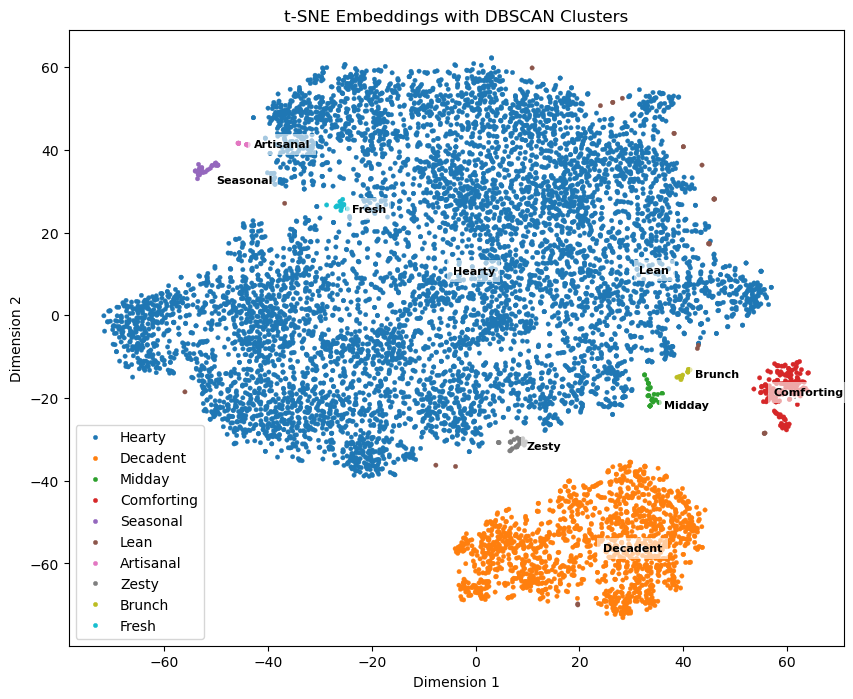

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Suppose you have:
# emb_2d: shape [num_points, 2]
# cluster_labels: numeric array from DBSCAN
# cluster_mapping: dict from numeric label -> descriptive cluster name

cluster_mapping = {
    -1: "Lean",
     0: "Hearty",
     1: "Decadent",
     2: "Midday",
     3: "Comforting",
     4: "Seasonal",
     5: "Artisanal",
     6: "Zesty",
     7: "Brunch",
     8: "Fresh"
}

# Convert numeric labels to descriptive strings
cluster_names = np.array([cluster_mapping[label] for label in cluster_labels])

plt.figure(figsize=(10,8))
sns.scatterplot(
    x=emb_2d[:, 0],
    y=emb_2d[:, 1],
    hue=cluster_names,
    palette="tab10",
    s=10,
    alpha=1,       # Slight transparency
    edgecolor=None,
    legend="brief"   # or "full" or False if you prefer
)
plt.title("t-SNE Embeddings with DBSCAN Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Collect cluster centroids
unique_names = np.unique(cluster_names)
text_labels = []
for name in unique_names:
    mask = (cluster_names == name)
    x_centroid = emb_2d[mask, 0].mean()
    y_centroid = emb_2d[mask, 1].mean()
    x_centroid += 2  # offset for better label placement
    y_centroid -= 2  # offset for better label placement
    # Place text with a bounding box for clarity
    txt = plt.text(
        x_centroid, y_centroid, name,
        fontsize=8, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )
    text_labels.append(txt)

# Use adjustText to avoid overlapping text labels
adjust_text(text_labels, arrowstyle="->", arrowprops=dict(color='black', lw=0.5))

plt.show()

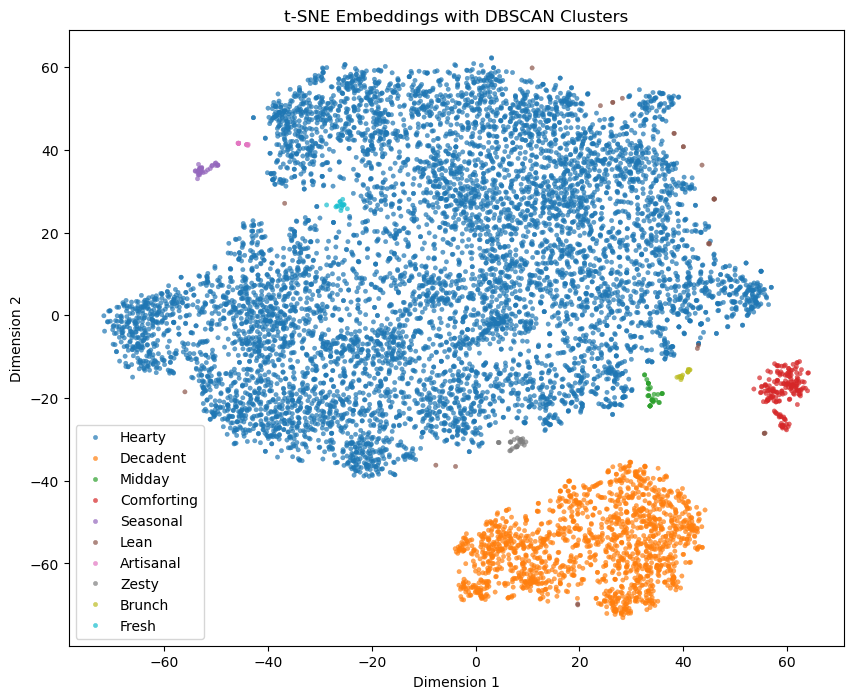

In [28]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=emb_2d[:, 0],
    y=emb_2d[:, 1],
    hue=cluster_names,  # maps numeric labels to descriptive cluster names
    palette="tab10",
    s=10,
    alpha=0.7,
    edgecolor=None,
    legend="brief"      # or "full" for all labels
)
plt.title("t-SNE Embeddings with DBSCAN Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [14]:
# Suppose df_recipes is a Pandas DataFrame with columns like "cuisine" and "meal_type"
# and the index of df_recipes matches the recipe IDs (0..68793).
import pandas as pd

df_recipes = pd.read_csv("recipes.csv")  # or however you load your recipe metadata

# Create a DataFrame for just the sampled recipes
df_sample = df_recipes.iloc[indices].copy()
df_sample["cluster_label"] = cluster_labels  # from dbscan.fit_predict(emb_2d)

FileNotFoundError: [Errno 2] No such file or directory: 'recipes.csv'

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=10)  # Tune eps based on t-SNE
clusters = dbscan.fit_predict(emb_2d)

In [77]:
import pandas as pd
import numpy as np

# Dataframe with original embeddings
df_original = pd.DataFrame(sample_emb)
df_original['cluster'] = clusters

# Compute mean embeddings per cluster
cluster_means = df_original.groupby('cluster').mean()
print(cluster_means.head())

ValueError: Length of values (68794) does not match length of index (10000)

In [78]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_emb)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=clusters, palette='tab10', s=5, alpha=0.7)
plt.title('PCA of Original Embeddings colored by DBSCAN Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

print('Explained variance ratio:', pca.explained_variance_ratio_)

ValueError: All arrays must be of the same length

<Figure size 800x600 with 0 Axes>

In [79]:
# Compute cluster-wise mean embeddings
cluster_means = pd.DataFrame(sample_emb).assign(cluster=clusters).groupby('cluster').mean()

# Compute top features distinguishing clusters
for cluster in cluster_means.index:
    print(f"\nTop features for Cluster {cluster}:")
    top_features = np.argsort(-np.abs(cluster_means.loc[cluster]))[:5]
    for feature in top_features:
        print(f"Feature {feature}: Mean = {cluster_means.loc[cluster][feature]:.3f}")

ValueError: Length of values (68794) does not match length of index (10000)

In [80]:
from sklearn.metrics.pairwise import euclidean_distances

centroids = []
for cluster_label in set(clusters):
    cluster_points = sample_emb[clusters == cluster]
    centroid = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    representative_index = indices[clusters == cluster][np.argmin(distances)]
    print(f"Representative Recipe for Cluster {cluster}:", representative_index)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 68794

In [81]:
# Assuming labels are available:
labels = data["recipe"].x[indices].cpu().numpy()
df_labels = pd.DataFrame({'Cluster': clusters, 'Label': labels})
cluster_distribution = df_labels.groupby('Cluster')['Label'].value_counts(normalize=True)
print(cluster_distribution)

ValueError: Per-column arrays must each be 1-dimensional

In [63]:
import pandas as pd

# Load recipes dataset
recipes = pd.read_csv('/Users/samlaborde-balen/Desktop/MLP project/Project/RecipeMAG/data/kaggle_data/RAW_recipes.csv')

# Drop missing essential data and duplicates
recipes.dropna(subset=['name', 'ingredients', 'tags', 'steps'], inplace=True)
recipes.drop_duplicates(subset='name', inplace=True)

# Lowercase text fields for consistency
recipes['ingredients'] = recipes['ingredients'].str.lower()
recipes['tags'] = recipes['tags'].str.lower()

# Nutrition preprocessing function
def preprocess_nutrition(df):
    nutrition_cols = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                      'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
    
    df[nutrition_cols] = df['nutrition'].str.split(",", expand=True)
    df['calories'] = df['calories'].str.replace('[','', regex=False)
    df['carbohydrates (PDV)'] = df['carbohydrates (PDV)'].str.replace(']','', regex=False)
    
    df[nutrition_cols] = df[nutrition_cols].astype(float)
    return df

# Apply nutrition preprocessing
recipes = preprocess_nutrition(recipes)

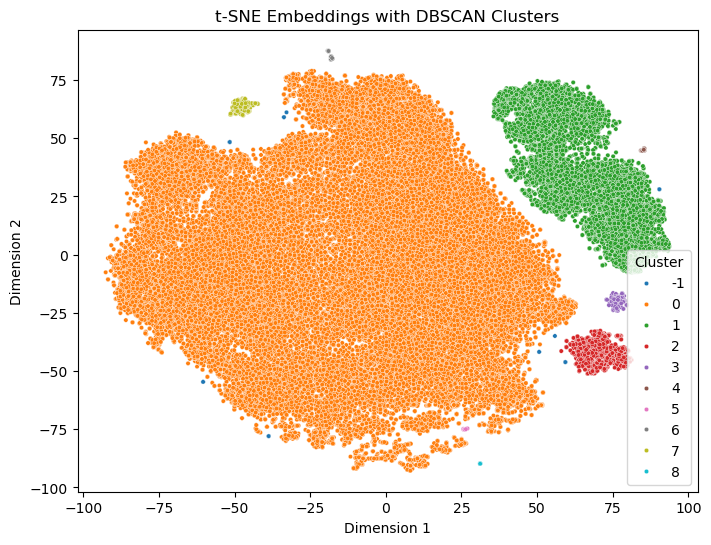

In [64]:
from sklearn.cluster import DBSCAN

# Cluster with DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10)
cluster_labels = dbscan.fit_predict(emb_2d)

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=cluster_labels, palette="tab10", s=10)
plt.title("t-SNE Embeddings with DBSCAN Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [65]:
# Your indices and clusters from earlier (assuming they're computed already)
indices = indices.cpu().numpy()  # torch to numpy if necessary
cluster_labels = cluster_labels  # from DBSCAN
recipes_sampled = recipes.iloc[indices].copy()
recipes_sampled['cluster'] = cluster_labels

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [67]:
def analyze_cluster(df, cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    ingredients = cluster_data['ingredients'].str.cat(sep=', ').split(', ')
    tags = cluster_data['tags'].str.cat(sep=',').split(',')

    ingredient_freq = pd.Series(ingredients).value_counts().head(10)
    tag_freq = pd.Series(tags).value_counts().head(10)
    
    print(f"\n--- Cluster {cluster_id} Analysis ---")
    print("Top Ingredients:\n", ingredient_freq)
    print("Top Tags:\n", tag_freq)

# Example usage for each cluster:
for cluster in sorted(recipes_sampled['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise cluster
    analyze_cluster(recipes_sampled, cluster)


--- Cluster 0 Analysis ---
Top Ingredients:
 'salt'             19455
'butter'           10537
'sugar'             9805
'onion'             8781
'eggs'              7391
'water'             6531
'milk'              5890
'garlic cloves'     5490
'flour'             5453
'olive oil'         5041
Name: count, dtype: int64
Top Tags:
 'preparation'         56334
'course'              52308
'time-to-make'        44901
'main-ingredient'     42238
'dietary'             39241
'easy'                30209
'occasion'            28099
'cuisine'             21596
'low-in-something'    19023
'main-dish'           17367
Name: count, dtype: int64

--- Cluster 1 Analysis ---
Top Ingredients:
 'salt'             3543
'butter'           1892
'sugar'            1727
'onion'            1622
'eggs'             1350
'water'            1219
'milk'             1061
'flour'             951
'garlic cloves'     942
'olive oil'         900
Name: count, dtype: int64
Top Tags:
 'preparation'         10097
'course'  

In [68]:
def analyze_cluster(df, cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    ingredients = cluster_data['ingredients'].str.cat(sep=', ').split(', ')
    tags = cluster_data['tags'].str.cat(sep=',').split(',')

    ingredient_freq = pd.Series(ingredients).value_counts().head(10)
    tag_freq = pd.Series(tags).value_counts().head(10)
    
    print(f"\n--- Cluster {cluster_id} Analysis ---")
    print("Top Ingredients:\n", ingredient_freq)
    print("Top Tags:\n", tag_freq)

# Example usage for each cluster:
for cluster in sorted(recipes_sampled['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise cluster
    analyze_cluster(recipes_sampled, cluster)


--- Cluster 0 Analysis ---
Top Ingredients:
 'salt'             19455
'butter'           10537
'sugar'             9805
'onion'             8781
'eggs'              7391
'water'             6531
'milk'              5890
'garlic cloves'     5490
'flour'             5453
'olive oil'         5041
Name: count, dtype: int64
Top Tags:
 'preparation'         56334
'course'              52308
'time-to-make'        44901
'main-ingredient'     42238
'dietary'             39241
'easy'                30209
'occasion'            28099
'cuisine'             21596
'low-in-something'    19023
'main-dish'           17367
Name: count, dtype: int64

--- Cluster 1 Analysis ---
Top Ingredients:
 'salt'             3543
'butter'           1892
'sugar'            1727
'onion'            1622
'eggs'             1350
'water'            1219
'milk'             1061
'flour'             951
'garlic cloves'     942
'olive oil'         900
Name: count, dtype: int64
Top Tags:
 'preparation'         10097
'course'  

In [22]:
nutrition_cols = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                  'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']

nutrition_summary = recipes_sampled.groupby('cluster')[nutrition_cols].mean()
print("\nNutrition profiles by cluster:")
print(nutrition_summary)

NameError: name 'recipes_sampled' is not defined

In [73]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

representative_recipes = {}
for cluster in recipes_sampled['cluster'].unique():
    if cluster == -1:
        continue  # Skip noise cluster
    cluster_embeddings = sample_emb[cluster_labels == cluster]
    centroid = cluster_embeddings.mean(axis=0)
    closest, _ = pairwise_distances_argmin_min([centroid], cluster_embeddings)
    
    representative_recipe = recipes_sampled.iloc[closest[0]]
    representative_recipes[cluster] = representative_recipe['name']
    print(f"Cluster {cluster} representative recipe:", representative_recipe['name'])

Cluster 0 representative recipe: budget stretching beef and zucchini enchiladas w brown rice
Cluster 1 representative recipe: blue onion bistro s macaroni and blue cheese with chives
Cluster 2 representative recipe: black christmas
Cluster 3 representative recipe: allergy friendly double chocolate brownies
Cluster 4 representative recipe: chessie s fruit dip
Cluster 5 representative recipe: cube steak roll ups
Cluster 6 representative recipe: arabic 7 seven spice  bokharat
Cluster 7 representative recipe: berry tofu smoothie
Cluster 8 representative recipe: caramel mud cake cupcakes
